<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-test-of-EfficientDet0" data-toc-modified-id="quick-test-of-EfficientDet0-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick test of EfficientDet0</a></span><ul class="toc-item"><li><span><a href="#data" data-toc-modified-id="data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#coco-labels" data-toc-modified-id="coco-labels-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>coco labels</a></span></li><li><span><a href="#model" data-toc-modified-id="model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>model</a></span></li></ul></li><li><span><a href="#Sources" data-toc-modified-id="Sources-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sources</a></span></li></ul></div>

# Car Detection
Research related to object detection using car detection dataset as an example.


In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## quick test of EfficientDet0

### data

In [2]:
# read sample image
img = cv2.imread('../samples/vid_5_26720.jpg')
img.shape

(380, 676, 3)

In [3]:
# resize
width = 1024
height = 1024
img = cv2.resize(img, (width, height))

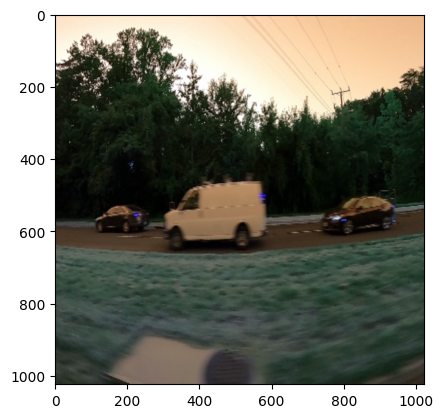

In [4]:
# show the image
plt.imshow(img)
plt.show()

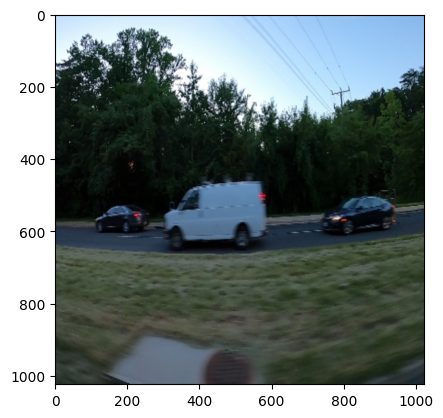

In [5]:
# convert bgr to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [7]:
img.shape

(1024, 1024, 3)

A three-channel image of variable size - the model does NOT support batching. The input tensor is a tf.uint8 tensor with shape [1, height, width, 3] with values in [0, 255].

In [6]:
# creating tensor and convert to uint8
img_tensor = tf.convert_to_tensor(img, dtype=tf.uint8)

In [7]:
img_tensor.shape

TensorShape([1024, 1024, 3])

In [8]:
# adding extra dimension
img_tensor = tf.expand_dims(img_tensor, 0)
img_tensor.shape

TensorShape([1, 1024, 1024, 3])

### coco labels

In [45]:
import pandas as pd

In [46]:
labels_coco = pd.read_csv('../samples/labels.csv', sep=';', index_col='ID')

In [47]:
labels_coco.head()

,OBJECT (PAPER),OBJECT (2014 REL.),OBJECT (2017 REL.),SUPER CATEGORY
ID,,,,
1,person,person,person,person
2,bicycle,bicycle,bicycle,vehicle
3,car,car,car,vehicle
4,motorcycle,motorcycle,motorcycle,vehicle
5,airplane,airplane,airplane,vehicle


In [48]:
# take only 2017 categories
labels_coco = np.array(labels_coco['OBJECT (2017 REL.)'])

### model

In [13]:
import tensorflow_hub as hub

In [14]:
# loading detector
detector = hub.load("https://tfhub.dev/tensorflow/efficientdet/d0/1")

In [15]:
# make sample prediction
detector_output = detector(img_tensor)

In [16]:
detector_output.keys()

dict_keys(['num_detections', 'detection_anchor_indices', 'detection_boxes', 'detection_multiclass_scores', 'raw_detection_scores', 'detection_scores', 'raw_detection_boxes', 'detection_classes'])

In [54]:
# Processing outputs
boxes, scores, classes =\
    detector_output['detection_boxes'],\
    detector_output['detection_scores'],\
    detector_output['detection_classes']

In [55]:
pred_labels = classes.numpy().astype('int')[0] 
pred_boxes = boxes.numpy()[0].copy()
pred_scores = scores.numpy()[0]

In [56]:
# get boxes with minimum score
score_threshold = 0.5
choosen_matrix = pred_scores > score_threshold
choosen_matrix

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [57]:
pred_boxes = pred_boxes[choosen_matrix]
pred_boxes

array([[0.4930913 , 0.71427476, 0.5987405 , 0.92279124],
       [0.5138847 , 0.1068649 , 0.59374815, 0.2583142 ],
       [0.45497003, 0.28763774, 0.6437224 , 0.58297646]], dtype=float32)

In [63]:
# inverse bbox cors vals
pred_boxes[:,0] = pred_boxes[:,0] * height
pred_boxes[:,1] = pred_boxes[:,1] * width
pred_boxes[:,2] = pred_boxes[:,2] * height
pred_boxes[:,3] = pred_boxes[:,3] * width
pred_boxes = pred_boxes.astype(np.int32)

In [58]:
# get classes names from coco
pred_labels = pred_labels[choosen_matrix]
pred_labels = labels_coco[pred_labels-1]
pred_labels

array(['car', 'car', 'truck'], dtype=object)

In [98]:
# copy of an image
img_boxes = img.copy()

In [99]:
# draw boxes and scores on detected objects
how_many_boxes = 0
for score, (ymin,xmin,ymax,xmax), label in zip(pred_scores, pred_boxes, pred_labels):
    print(f"got it ! | {xmin}, {xmax}, {ymin}, {ymax}, score {score}")
    score_txt = f'{100 * score:.4}%'
    img_boxes = cv2.rectangle(img_boxes,(xmin, ymax),(xmax, ymin),(0,255,0),2)      
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_boxes, label,(xmin, ymin-40), font, 2.0, (255,0,0), 3, cv2.LINE_AA)
    cv2.putText(img_boxes,score_txt,(xmin, ymin-10), font, 1.0, (255,0,0), 2, cv2.LINE_AA)
    
    how_many_boxes += 1
    
print(f"There is {how_many_boxes} boxes")q

got it ! | 731, 944, 504, 613, score 0.9014322757720947
got it ! | 109, 264, 526, 607, score 0.8695728182792664
got it ! | 294, 596, 465, 659, score 0.7608039379119873
There is 3 boxes


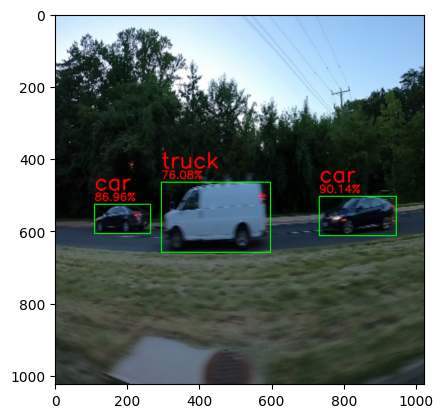

True

In [100]:
plt.imshow(img_boxes)
plt.show()
cv2.imwrite("output.jpg", img_boxes)

## Sources
- https://towardsdatascience.com/object-detection-with-tensorflow-model-and-opencv-d839f3e42849